In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import sklearn.preprocessing as preproc
from scipy import stats

# Dealing with Counts
## Binarizing

<p>Dataset: Million Song Dataset, contains the full music listening histories of one million users on Echo Nest.</p>
<p>Task: 建立一個推薦器向用戶推薦歌曲</p>
<p>The table contains user-song-count triplets. Only nonzero counts are included. Hence, to binarize the count, we just need to set the entire count column to 1.</p>

In [2]:
listen_count = pd.read_csv('train_triplets.txt', header=None, delimiter='\t')

In [3]:
listen_count.head()

,0,1,2
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


/Users/winniewu/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


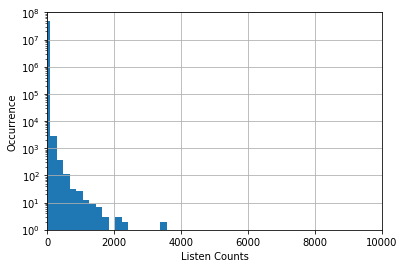

In [3]:
h = plt.hist(listen_count[2], bins=50, log=True, align='left')
plt.xlabel('Listen Counts')
plt.ylabel('Occurrence')
plt.axis([0, 10000, 0, 10**8])
plt.grid(True)
plt.show()

In [4]:
listen_count[2] = 1

In [5]:
listen_count.head()

,0,1,2
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


## Quantization or Binning

<p>Dataset: The Yelp dataset contains user reviews of businesses from 10 cities across North America and Europe.</p> <p>Each business is labeled with zero or more categories.</p>
<p>Task: 使用協同過濾來預測用戶可能給企業的評級</p>
<p>評論數量可能是有用的inputs...因為越多人評論跟他的好壞有很強的相關性</p>

In [6]:
biz_file = open('yelp_dataset/business.json')
biz_df = pd.DataFrame([json.loads(x) for x in biz_file.readlines()]) 
biz_file.close()

In [8]:
biz_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,None,0,33.522143,-112.018481,Arizona Biltmore Golf Club,85016,5,3.0,AZ
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",1,43.605499,-79.652289,Emerald Chinese Restaurant,L5R 3E7,128,2.5,ON
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",1,35.092564,-80.859132,Musashi Japanese Restaurant,28210,170,4.0,NC
3,"15655 W Roosevelt St, Ste 237",None,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,33.455613,-112.395596,Farmers Insurance - Paul Lorenz,85338,3,5.0,AZ
4,"4209 Stuart Andrew Blvd, Ste F","{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi...",Charlotte,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",1,35.190012,-80.887223,Queen City Plumbing,28217,4,4.0,NC


Text(0,0.5,'Occurrence')

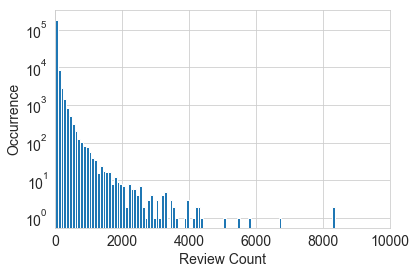

In [9]:
# Plot the histogram of the review counts
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100) 
ax.set_yscale('log')
ax.tick_params(labelsize=14)
ax.set_xlim([0,10000])
ax.set_xlabel('Review Count', fontsize=14)
ax.set_ylabel('Occurrence', fontsize=14)

#### 如上圖：大部分的評論都超少的，但還是有一些有大量的評論，這種範圍很廣的分佈，會對某些模型不好用
<p>eg. 線性模型, why?</p>
<p>eg. k-means, why?</p>

### Quantization maps a continuous number to a discrete one.
<p> We can think of the discretized numbers as an ordered sequence of bins that represent a measure of intensity.</p>

### We have to decide how wide each bin should be: fixed-width or adaptive?
<p>fixed-width: To map from the count to the bin, we simply divide by the width of the bin and take the integer part.</p>
<p>fixed-width的方法雖然簡單，但有時候當數據分佈過廣且有很大的間距的時候，有些bin會沒有值</p>

#### Quantile

In [10]:
deciles = biz_df['review_count'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])
deciles

0.1     3.0
0.2     4.0
0.3     5.0
0.4     7.0
0.5     9.0
0.6    13.0
0.7    19.0
0.8    33.0
0.9    70.0
Name: review_count, dtype: float64

Text(0,0.5,'Occurrence')

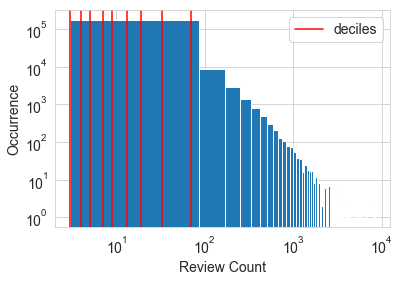

In [11]:
sns.set_style('whitegrid')
fig, ax = plt.subplots()
biz_df['review_count'].hist(ax=ax, bins=100) 
for pos in deciles:
    handle = plt.axvline(pos, color='r')
ax.legend([handle], ['deciles'], fontsize=14) 
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=14)
ax.set_xlabel('Review Count', fontsize=14) 
ax.set_ylabel('Occurrence', fontsize=14)

In [12]:
# Map the counts to quartiles
counts = biz_df['review_count']
counts.quantile([0.25, 0.5, 0.75, 0.99, 1])

0.25       4.0
0.50       9.0
0.75      25.0
0.99     396.0
1.00    8348.0
Name: review_count, dtype: float64

## Log Transformation

The log transform is a powerful tool for dealing with positive numbers with a heavy- tailed distribution.

### Example 1
dataset: Yelp

In [13]:
biz_df['log_review_count'] = np.log10(biz_df['review_count'])

(0, 15000)

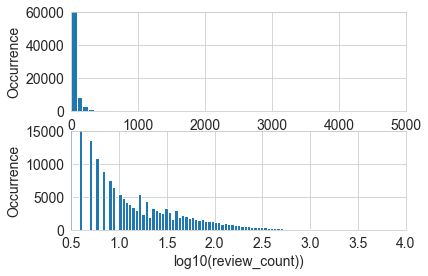

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1)

biz_df['review_count'].hist(ax=ax1, bins=100) 
ax1.tick_params(labelsize=14)
ax1.set_xlabel('review_count', fontsize=14) 
ax1.set_ylabel('Occurrence', fontsize=14)
ax1.set_xlim([0,5000])
ax1.set_ylim([0,60000])

biz_df['log_review_count'].hist(ax=ax2, bins=100) 
ax2.tick_params(labelsize=14)
ax2.set_xlabel('log10(review_count))', fontsize=14) 
ax2.set_ylabel('Occurrence', fontsize=14)
ax2.set_xlim([0.5,4.0])
ax2.set_ylim([0,15000])

### Example2
<p>Dataset: UC Irvine 機器學習庫的在線新聞流行數據集</p>
<p>Task: Our goal is to use these features to predict the popularity of the articles in terms of the number of shares on social media.</p>

In [15]:
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv')

In [16]:
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [17]:
df['log_n_tokens_content'] = np.log10(df[' n_tokens_content']+1)

Text(0,0.5,'Number of Articles')

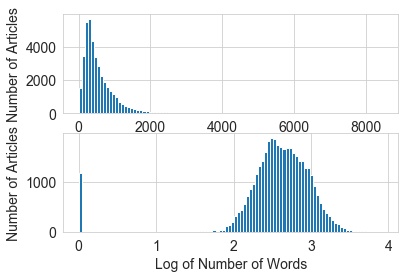

In [18]:
'''Notice that the distribution looks much more Gaussian after log transformation, 
with the exception of the burst of number of articles of length zero (no content).'''

fig, (ax1, ax2) = plt.subplots(2,1)
df[' n_tokens_content'].hist(ax=ax1, bins=100)
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Number of Words in Article', fontsize=14) 
ax1.set_ylabel('Number of Articles', fontsize=14)

df['log_n_tokens_content'].hist(ax=ax2, bins=100) 
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Log of Number of Words', fontsize=14) 
ax2.set_ylabel('Number of Articles', fontsize=14)

## Log Transformation in Action

<p> For the Yelp reviews dataset, 用評論的數量去預測一個商家平均的rating </p>
<p> Since the outputs are continuous numbers, we’ll use simple linear regression as the model. </p>

In [19]:
'''Note that we add 1 to the raw count to prevent the logarithm from 
exploding into negative infinity in case the count is zero.'''

biz_df['log_review_count'] = np.log10(biz_df['review_count'] + 1)

In [20]:
# Compare the 10-fold cross validation score of two models: with and without log transformation
m_orig = linear_model.LinearRegression()
scores_orig = cross_val_score(m_orig, biz_df[['review_count']], biz_df['stars'], cv=10)

m_log = linear_model.LinearRegression()
scores_log = cross_val_score(m_log, biz_df[['log_review_count']], biz_df['stars'], cv=10)

print("R-squared score without log transform: %0.5f (+/- %0.5f)" %(scores_orig.mean(), scores_orig.std() * 2))
print("R-squared score with log transform: %0.5f (+/- %0.5f)" %(scores_log.mean(), scores_log.std() * 2))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


R-squared score without log transform: 0.00160 (+/- 0.00090)
R-squared score with log transform: 0.00408 (+/- 0.00147)


<p> For the Mashable news articles, 用一個文章裡的字數去預測一個文章的熱門程度</p>

In [21]:
df['log_n_tokens_content'] = np.log10(df[' n_tokens_content'] + 1)

In [22]:
m_orig = linear_model.LinearRegression()
scores_orig = cross_val_score(m_orig, df[[' n_tokens_content']], df[' shares'], cv=10)
m_log = linear_model.LinearRegression()
scores_log = cross_val_score(m_log, df[['log_n_tokens_content']], df[' shares'], cv=10)
print("R-squared score without log transform: %0.5f (+/- %0.5f)" % (scores_orig.mean(), scores_orig.std() * 2))
print("R-squared score with log transform: %0.5f (+/- %0.5f)" % (scores_log.mean(), scores_log.std() * 2))

R-squared score without log transform: -0.00242 (+/- 0.00509)
R-squared score with log transform: -0.00114 (+/- 0.00418)


### (NEED TO BE CLARIFIED!!!) Why is the log transform so much more successful on this dataset?

(0, 100000)

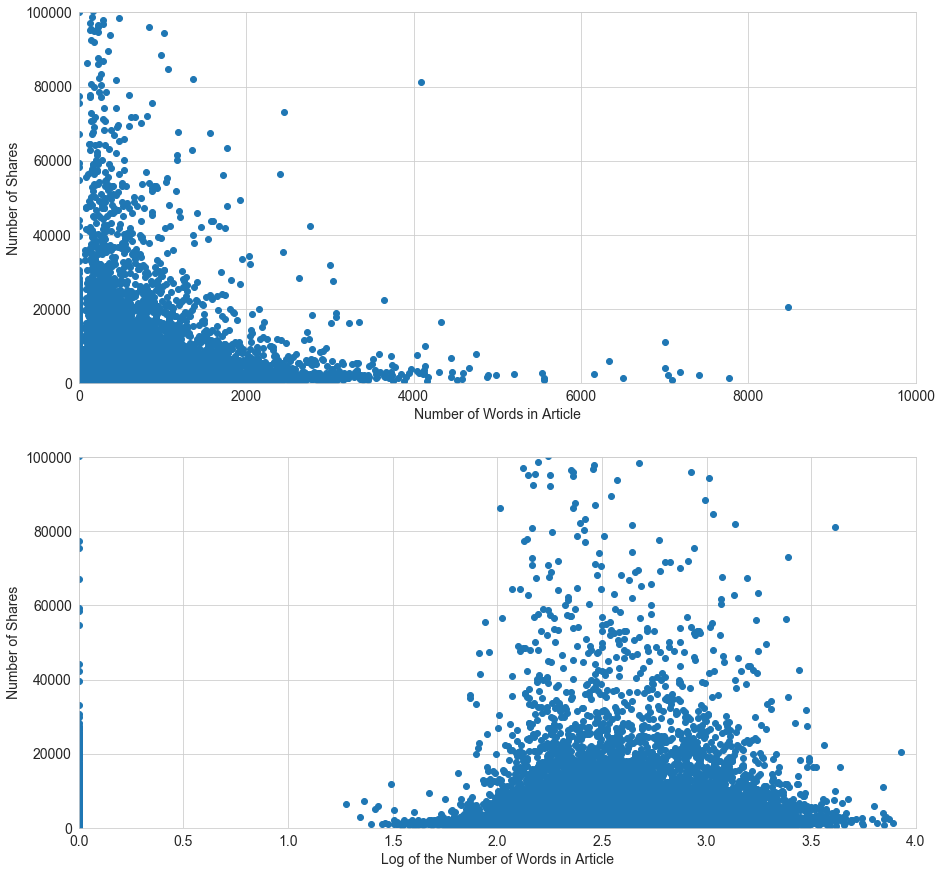

In [23]:
fig2, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))

ax1.scatter(df[' n_tokens_content'], df[' shares'])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Number of Words in Article', fontsize=14) 
ax1.set_ylabel('Number of Shares', fontsize=14)
ax1.set_xlim([0, 10000])
ax1.set_ylim([0, 100000])


ax2.scatter(df['log_n_tokens_content'], df[' shares'])
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Log of the Number of Words in Article', fontsize=14) 
ax2.set_ylabel('Number of Shares', fontsize=14)
ax2.set_xlim([0.0, 4.0])
ax2.set_ylim([0, 100000])

As can be seen in the bottom panel, the log transform reshaped the x-axis, pulling the articles with large outliers in the target value (>200,000 shares) further out toward the righthand side of the axis. This gives the linear model more “breathing room” on the low end of the input feature space. Without the log transform (top panel), the model is under more pressure to fit very different target values under very small changes in the input.

(1, 5)

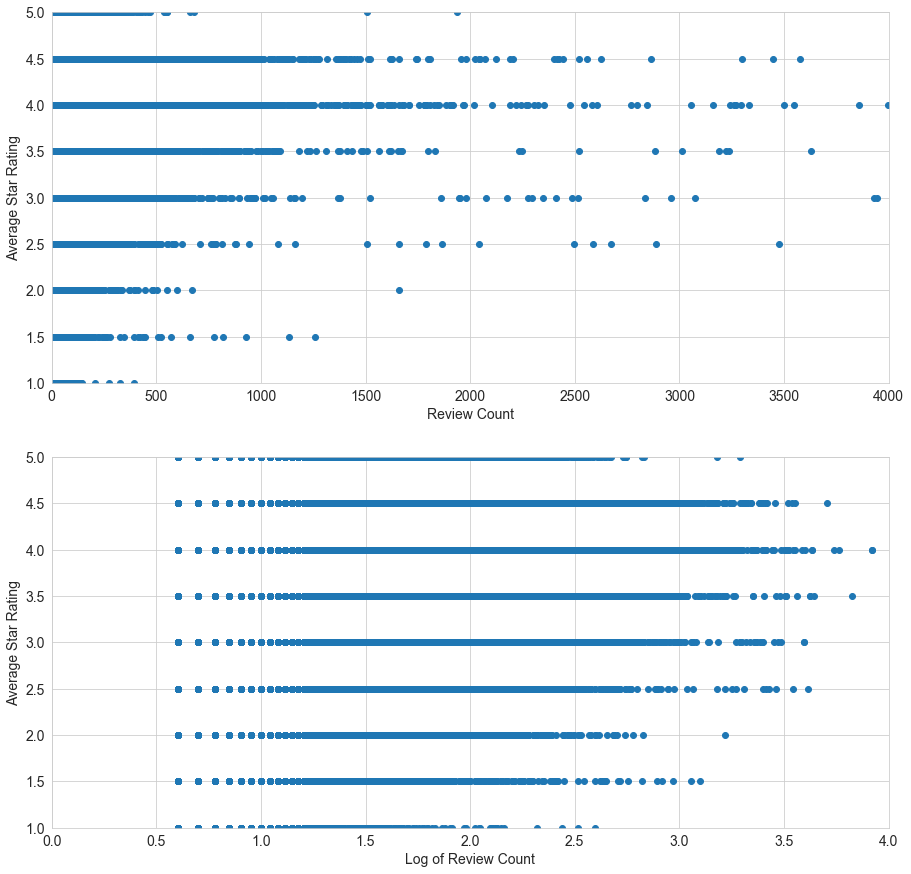

In [24]:
fig3, (ax1, ax2) = plt.subplots(2,1, figsize=(15,15))

ax1.scatter(biz_df['review_count'], biz_df['stars'])
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Review Count', fontsize=14) 
ax1.set_ylabel('Average Star Rating', fontsize=14)
ax1.set_xlim([0, 4000])
ax1.set_ylim([1,5])


ax2.scatter(biz_df['log_review_count'], biz_df['stars'])
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Log of Review Count', fontsize=14) 
ax2.set_ylabel('Average Star Rating', fontsize=14)
ax2.set_xlim([0.0, 4.0])
ax2.set_ylim([1, 5])

The average star rating is discretized in increments of half-stars ranging from 1 to 5. High review counts (roughly >2,500 reviews) do correlate with higher average star ratings, but the relationship is far from linear. There is no clear way to draw a line to predict the aver‐ age star rating based on either input. Essentially, the plot shows that review count and its logarithm are both bad linear predictors of average star rating.

## Box-Cox transformation 

- In statistical terms, these are variance-stabilizing transformations.
- 數據需為正值。對於非正數據, 可以通過加上固定常量來移動數值
- SciPy’s stats package contains an implementation of the Box-Cox transformation that includes finding the optimal transform parameter.
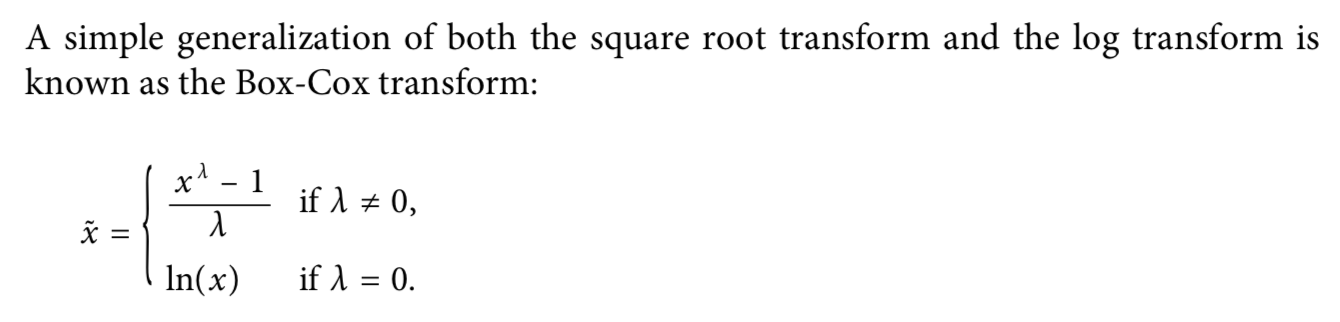

In [25]:
# The Box-Cox transform assumes that input data is positive. Check the min to make sure.
biz_df['review_count'].min()

3

In [26]:
# Setting input parameter lmbda to 0 gives us the log transform (without constant offset)
rc_log = stats.boxcox(biz_df['review_count'], lmbda=0)
biz_df['rc_log'] = rc_log

In [33]:
# By default, the scipy implementation of Box-Cox transform finds the lambda 
# parameter that will make the output the closest to a normal distribution
rc_bc, bc_params = stats.boxcox(biz_df['review_count'])
biz_df['rc_bc'] = rc_bc
print(bc_params)

-0.37107910850437914


Text(0,0.5,'Occurrence')

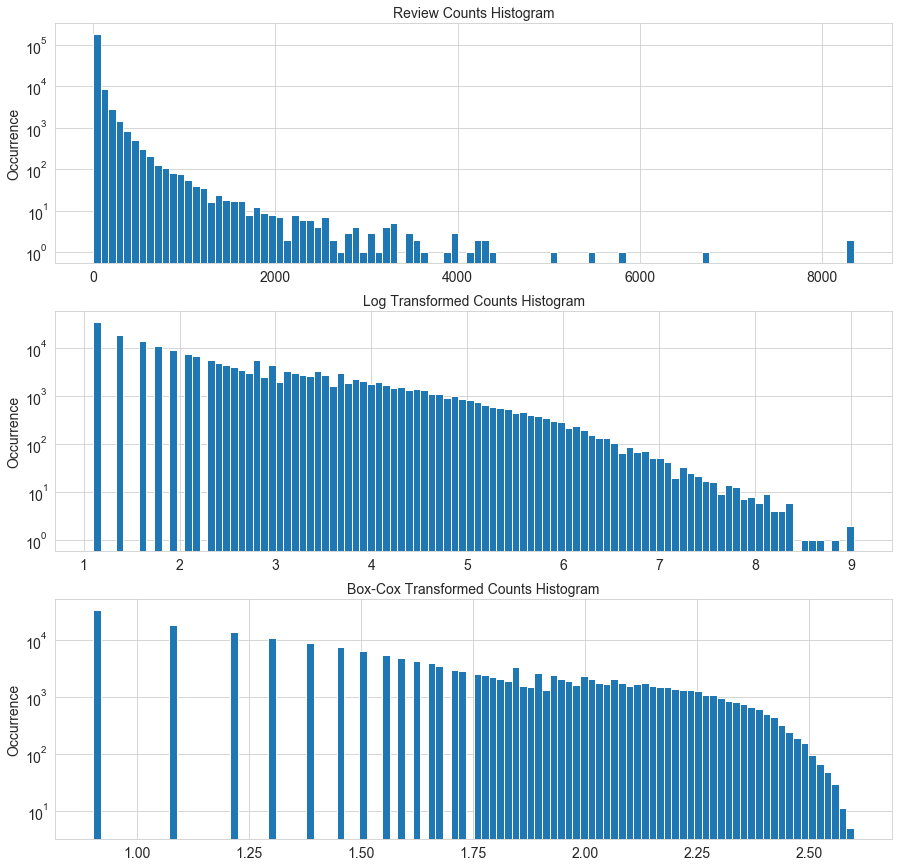

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))
# original review count histogram
biz_df['review_count'].hist(ax=ax1, bins=100)
ax1.set_yscale('log')
ax1.tick_params(labelsize=14)
ax1.set_title('Review Counts Histogram', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Occurrence', fontsize=14)

# review count after log transform
biz_df['rc_log'].hist(ax=ax2, bins=100)
ax2.set_yscale('log')
ax2.tick_params(labelsize=14)
ax2.set_title('Log Transformed Counts Histogram', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Occurrence', fontsize=14)

# review count after optimal Box-Cox transform 
biz_df['rc_bc'].hist(ax=ax3, bins=100) 
ax3.set_yscale('log')
ax3.tick_params(labelsize=14)
ax3.set_title('Box-Cox Transformed Counts Histogram', fontsize=14)
ax3.set_xlabel('')
ax3.set_ylabel('Occurrence', fontsize=14)

### Probability plots of original and transformed counts against the normal distribution
- A probability plot, or probplot, is an easy way to visually compare an empirical distribution of data against a theoretical distribution. 
- This is essentially a scatter plot of observed versus theoretical quantiles. 

Text(0.5,1,'Probplot after Box-Cox transform')

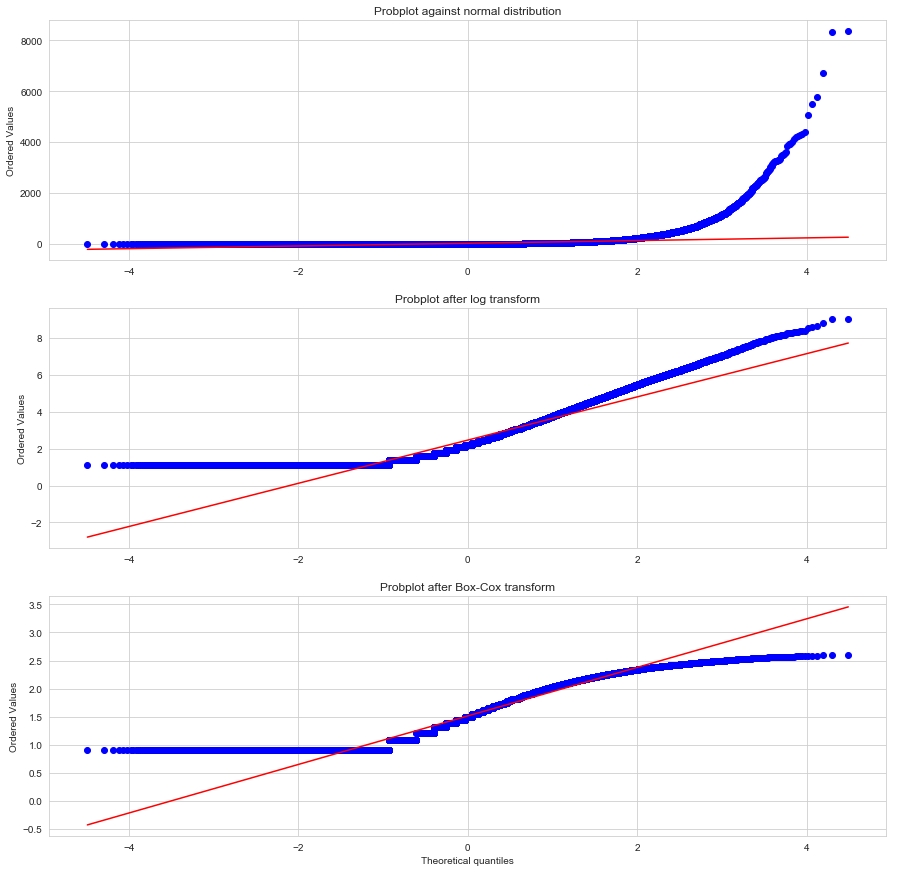

In [29]:
fig2, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,15))
prob1 = stats.probplot(biz_df['review_count'], dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

prob2 = stats.probplot(biz_df['rc_log'], dist=stats.norm, plot=ax2)
ax2.set_xlabel('')
ax2.set_title('Probplot after log transform')

prob3 = stats.probplot(biz_df['rc_bc'], dist=stats.norm, plot=ax3)
ax3.set_xlabel('Theoretical quantiles')
ax3.set_title('Probplot after Box-Cox transform')

## feature normalization

### Min-Max Scaling / Standardization (Variance Scaling) /  l2 Normalization

#### Min-Max: 把最大值和最小值的區間縮到0~1之間
#### Standardization: 把數值平均變為零，標準差變成1
#### l2 normalization (Euclidean norm): feature的l2範數等於1

In [30]:
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv', delimiter=', ')
df['n_tokens_content'].as_matrix()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([219., 255., 211., ..., 442., 682., 157.])

In [31]:
df['minmax'] = preproc.minmax_scale(df[['n_tokens_content']])
print(df['minmax'].as_matrix())
df['standardized'] = preproc.StandardScaler().fit_transform(df[['n_tokens_content']])
print(df['standardized'].as_matrix())
df['l2_normalized'] = preproc.normalize(df[['n_tokens_content']], axis=0)
print(df['l2_normalized'].as_matrix())

[0.02584376 0.03009205 0.02489969 ... 0.05215955 0.08048147 0.01852726]
[-0.69521045 -0.61879381 -0.71219192 ... -0.2218518   0.28759248
 -0.82681689]
[0.00152439 0.00177498 0.00146871 ... 0.00307663 0.0047472  0.00109283]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Text(0,0.5,'Number of articles')

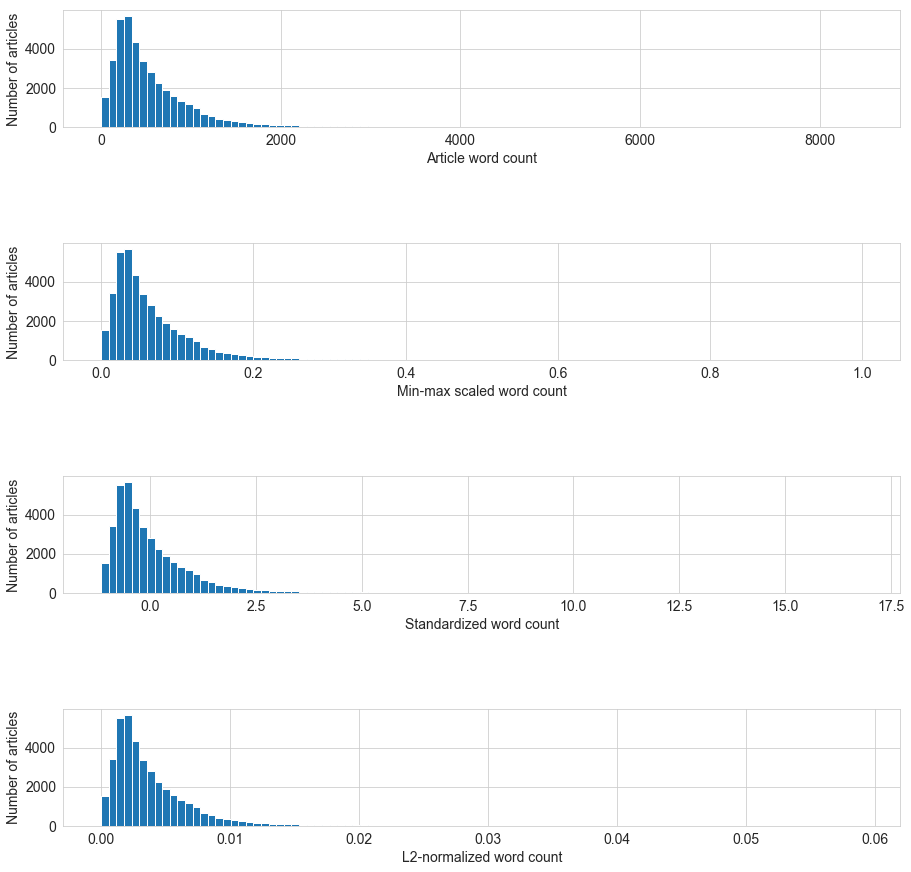

In [38]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,15)) 
fig.subplots_adjust(wspace =0, hspace =1)
df['n_tokens_content'].hist(ax=ax1, bins=100) 
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Article word count', fontsize=14) 
ax1.set_ylabel('Number of articles', fontsize=14)

df['minmax'].hist(ax=ax2, bins=100)
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Min-max scaled word count', fontsize=14) 
ax2.set_ylabel('Number of articles', fontsize=14)

df['standardized'].hist(ax=ax3, bins=100)
ax3.tick_params(labelsize=14)
ax3.set_xlabel('Standardized word count', fontsize=14) 
ax3.set_ylabel('Number of articles', fontsize=14)

df['l2_normalized'].hist(ax=ax4, bins=100)
ax4.tick_params(labelsize=14)
ax4.set_xlabel('L2-normalized word count', fontsize=14) 
ax4.set_ylabel('Number of articles', fontsize=14)

## interaction features

- A simple pairwise interaction feature is the product of two features.

In [39]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
import sklearn.preprocessing as preproc

In [40]:
df = pd.read_csv('OnlineNewsPopularity/OnlineNewsPopularity.csv', delimiter=', ')
df.columns

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

In [41]:
# Select the content-based features as singleton features in the model,
# skipping over the derived features

features = ['n_tokens_title', 'n_tokens_content',
            'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
            'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
            'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
            'data_channel_is_entertainment', 'data_channel_is_bus',
            'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world']

X = df[features] 
y = df[['shares']]

In [42]:
# Create pairwise interaction features, skipping the constant bias term
X2 = preproc.PolynomialFeatures(include_bias=False).fit_transform(X) 
X2.shape

(39644, 170)

In [43]:
# Create train/test sets for both feature sets
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X, X2, y, test_size=0.3, random_state=123)

In [44]:
def evaluate_feature(X_train, X_test, y_train, y_test):
    """Fit a linear regression model on the training set and
    score on the test set"""
    model = linear_model.LinearRegression().fit(X_train, y_train)
    r_score = model.score(X_test, y_test)
    return (model, r_score)

In [45]:
# Train models and compare score on the two feature sets
(m1, r1) = evaluate_feature(X1_train, X1_test, y_train, y_test) 
(m2, r2) = evaluate_feature(X2_train, X2_test, y_train, y_test) 
print("R-squared score with singleton features: %0.5f" % r1) 
print("R-squared score with pairwise features: %0.10f" % r2)

R-squared score with singleton features: 0.00924
R-squared score with pairwise features: 0.0112526318


## feature selection
### feature selection techniques fall into three classes:
#### Filtering:
1. 篩選掉對模型不重要的特徵
2. 計算和Y或其他特徵的相關係數
3. cheap

#### Wrapper methods:
1. 為每個特徵子集訓練一個新模型，使用預測模型給特徵子集打分

#### Embedded methods:
1. 決策樹
2. L1標準化
